In [18]:
import numpy as np
import nolds
from matplotlib import pyplot as plt
from numpy import linalg as la
import os
from scipy import stats
from scipy import spatial as sp
from scipy import sparse
from sklearn import linear_model
from scipy import linalg as sla

import lyapynov as le

import pandas as pd
import networkx as nx

import SystemsSolved as s
import Methods as m

import Sparse_Reservoir_Computing as rc

import RecurrencePlotsCode as rp

import multiprocess as mp

In [19]:
R = s.rossler(a=0.2, b=0.2, c=5.7)
Rts = R.solve(t0=0, tFinal=1000, x0 = [-1.5, -1.5, 10], dt=0.01)


In [20]:
def RC_set(sigma, rho, gamma, Rts=Rts):
    import Sparse_Reservoir_Computing as rc
    sigma = sigma #Drive
    rho = rho #Spectral Radius

    r = rc.Reservoir(Nodes = 100, InDim=3, seed=12)
    r.Weighted_Erdos_R(SpecRadius=rho, p=0.04)
    r.set_rdot(sigma = sigma, gamma = gamma)
    r.Set_W_in_Matrix() #Error from normalising specral radius

    rc1 = rc.RC(SparseReservoir=r, U=Rts, dt = 0.01)

    rc1.Listening(time=700)
    rc1.Training(t0 = 500, tEnd = 700)
    rc1.Predicting(t0 = 700, tFinal = 1700)
    return rc1.uPrediction

def autocor_RC_test(Uhat, A0 = Rts):
    import numpy as np
    from scipy import stats
    r1_auto = np.correlate(Uhat[0, :], Uhat[0, :], mode='full')
    U_auto = np.correlate(A0[0, :], A0[0, :], mode='full')
    Auto_stat = stats.pearsonr(U_auto, r1_auto).statistic
    return Auto_stat


In [38]:
sigma_pts = np.linspace(0.01, 0.9, 10)
rho_pts = np.linspace(0.01, 0.9, 10)
gamma_pts = [1]

N = int(len(sigma_pts))
M = int(len(rho_pts))
K = len(gamma_pts)
params = []

for i in range(0, N):
      for j in range(0, M):
          for k in range(0, K):
               params.append([sigma_pts[i], rho_pts[j], gamma_pts[k]])

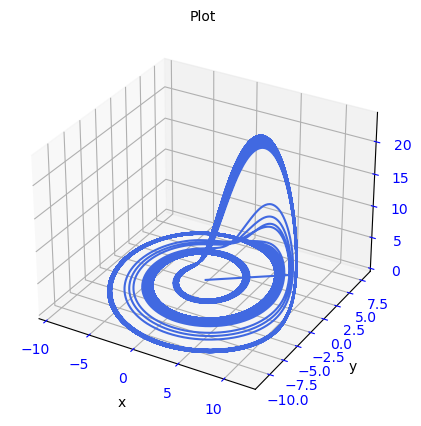

In [44]:
with mp.Pool(processes=6) as pool:
        results = pool.starmap_async(RC_set, params)
        L = results.get()

with mp.Pool(processes=6) as pool:
        results = pool.map_async(autocor_RC_test, L)
        RC_auto = results.get()

p = m.plot3D(cols = 1, rows=1, figsize=(5, 5))
index = np.argmax(RC_auto)
p.plot3D(L[index], plotNum=1)

In [ ]:
def gridSearchRC_parallell(sigma_pts, rho_pts, gamma_pts, U, processes = 1, t_evolve = 1000, t_listen = 700, t_train = 500, Nodes = 100, dt = 0.01 ):

    N = int(len(sigma_pts)); M = int(len(rho_pts)); K = len(gamma_pts)

    #Getting pts to test 
    params = []
    for i in range(0, N):
        for j in range(0, M):
            for k in range(0, K):
                params.append([sigma_pts[i], rho_pts[j], gamma_pts[k]])

    #Setting input nodes 
    Nodes = Nodes; dt = dt
    t_listen = t_listen; t_train = t_train; t_evolve = t_evolve

    #Function to generate reservoir prediction
    def RC_set(sigma, rho, gamma, Rts=U):
        import Sparse_Reservoir_Computing as rc
        sigma = sigma #Drive
        rho = rho #Spectral Radius

        r = rc.Reservoir(Nodes = 100, InDim=3, seed=12)
        r.Weighted_Erdos_R(SpecRadius=rho, p=0.04)
        r.set_rdot(sigma = sigma, gamma = gamma)
        r.Set_W_in_Matrix() #Error from normalising specral radius

        rc1 = rc.RC(SparseReservoir=r, U=U, dt = 0.01)

        rc1.Listening(time=700)
        rc1.Training(t0 = 500, tEnd = 700)
        rc1.Predicting(t0 = 700, tFinal = 1700)
        return rc1.uPrediction
   
    #test for correllation between autocorrellation 
    def autocor_RC_test(Uhat, A0 = Rts):
        import numpy as np
        from scipy import stats
        r1_auto = np.correlate(Uhat[0, :], Uhat[0, :], mode='full')
        U_auto = np.correlate(A0[0, :], A0[0, :], mode='full')
        Auto_stat = stats.pearsonr(U_auto, r1_auto).statistic
        return Auto_stat
    
    with mp.Pool(processes=processes) as pool:
        results = pool.starmap_async(RC_set, params)
        L = results.get()

    with mp.Pool(processes=processes) as pool:
            auto_res = pool.map_async(autocor_RC_test, L)
            var_res = pool.map_async(np.var, L)
            mean_res = pool.map_async(np.mean, L)
            Lauto = auto_res.get(); Lvar = var_res.get(); Lmean = mean_res.get()
        

    Lmean = np.array(Lmean); Lvar = np.array(Lvar); Lauto = np.array(Lauto)      

    U_mean = np.mean(U) - Lmean
    U_var = np.var(U) - Lvar
    i1 = np.argmin(U_mean); i2 = np.argmin(U_var); i3 = np.argmax(Lauto); I = [i1, i2, i3]

    #print(Lindex[i1]); print(Lindex[i2]); print(Lindex[i3])
    return L, I, params

In [27]:
sigma_pts = np.linspace(0.01, 0.9, 10); rho_pts = np.linspace(0.01, 0.9, 10); gamma_pts = np.linspace(0.8, 1.2, 5)
L, I, params = gridSearchRC_parallell(sigma_pts=sigma_pts, rho_pts=rho_pts, gamma_pts=gamma_pts, U=Rts, processes = 10, t_evolve = 1000, t_listen = 700, t_train = 500, Nodes = 100, dt = 0.01 )

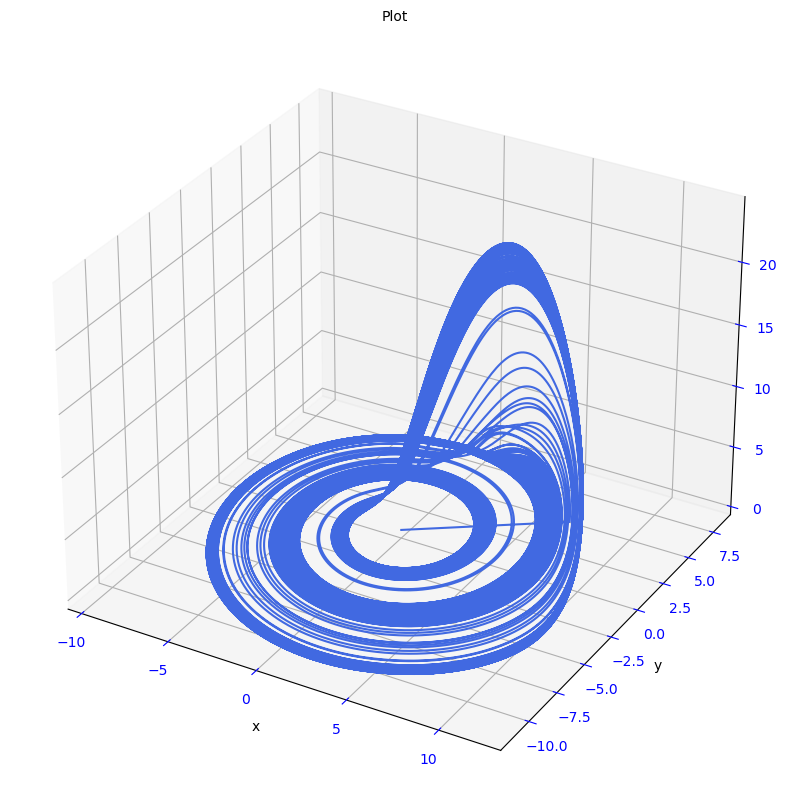

In [30]:
p = m.plot3D(cols = 1, rows = 1, figsize=(10, 10))
p.plot3D(L[I[2]], plotNum=1)

In [31]:
print(np.mean(Rts)); print(np.mean(L[I[2]]))
print(np.var(Rts)); print(np.var(L[I[2]]))
print(autocor_RC_test(L[I[2]], Rts))


0.05990151733213783
0.0665248304233009
19.795295918702582
20.163919846774196
0.636715101207666


In [32]:
params[I[2]]

[0.9, 0.6033333333333333, 1.2]

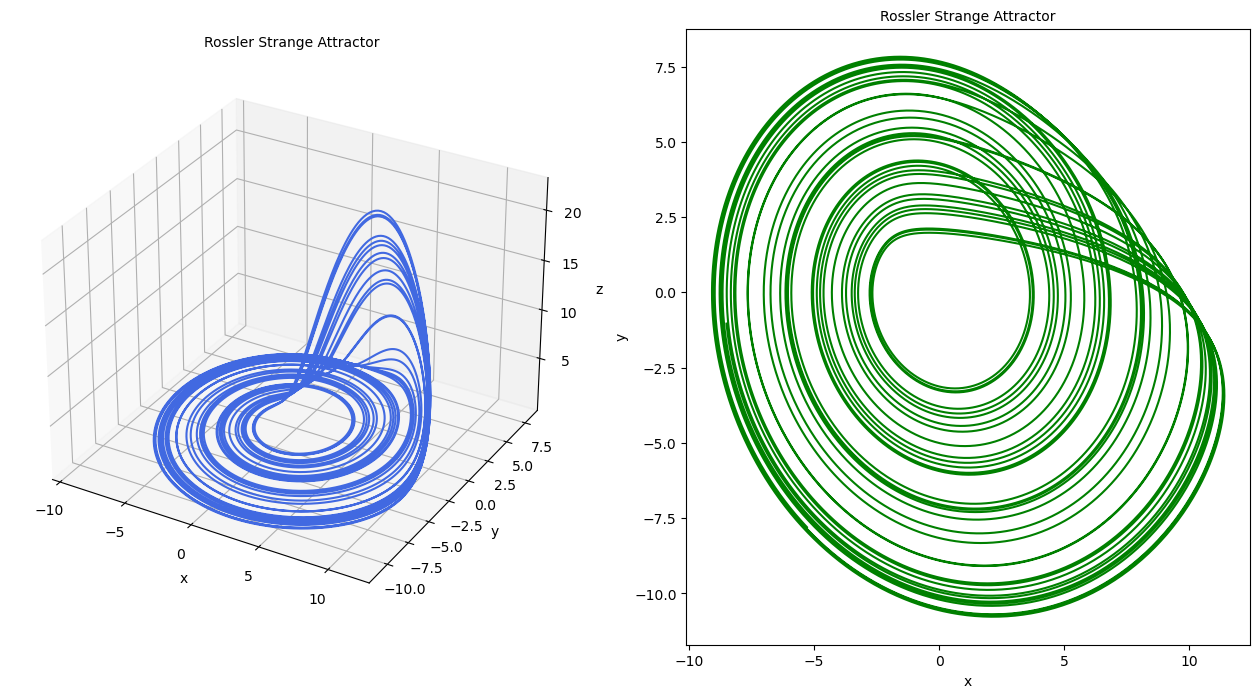

In [ ]:
p1 = m.plot3D(cols=2, rows=1, figsize=(16, 8))
p1.plot3D(Rts[:, 10000:30000], plotNum=1, tick_label_color='k', title="Rossler Strange Attractor")
p1.plot2D(Rts[0, 10000:30000], Rts[1, 10000:30000], plotNum=2, title="Rossler Strange Attractor")
title 